In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quaternion
import sympy
from sympy.abc import x,y,z
from sympy.utilities.codegen import codegen

In [2]:
# path = "../data/tst_cal_005.csv"
# path = "../test/tst_data/data5_tst_cal_004_onArmArbitraryMotions.csv"
# path = "../test/tst_data/data6_tst_cal_004_onArmArbitraryMotions.csv"
path = "../test/tst_data/data7_tst_cal_004_onArmArbitraryMotions.csv"
df = pd.read_csv(path)

# df.head(0)

class Observation:
    def __init__(self,omega1,omega2,q1,q2) -> None:
        self.qR     = q1.conj() * q2
        self.omegaR = quaternion.rotate_vectors(self.qR,omega2) - omega1

obs = []
obs_num = df.shape[0]

for i,row in df.iterrows():
    ## Retrieve data from csv file
    omega1 = np.array([ row['IMU_GYROSCOPE(0)_0'], row['IMU_GYROSCOPE(0)_1'], row['IMU_GYROSCOPE(0)_2']] )
    omega2 = np.array([ row['IMU_GYROSCOPE(1)_0'], row['IMU_GYROSCOPE(1)_1'], row['IMU_GYROSCOPE(1)_2']] )
    q1 = np.quaternion(row['IMU_QUATERNION(0)_0'], row['IMU_QUATERNION(0)_1'], row['IMU_QUATERNION(0)_2'], row['IMU_QUATERNION(0)_3'])
    q2 = np.quaternion(row['IMU_QUATERNION(1)_0'], row['IMU_QUATERNION(1)_1'], row['IMU_QUATERNION(1)_2'], row['IMU_QUATERNION(1)_3'])
    ## Add observation to buffer
    obs.append(Observation(omega1,omega2,q1,q2))

## Define equations

In [3]:
theta1,rho1,theta2,rho2 = sympy.symbols('theta_1 rho_1 theta_2 rho_2')
j1 = sympy.Matrix([
        sympy.sin(theta1)*sympy.cos(rho1),
        sympy.sin(theta1)*sympy.sin(rho1),
        sympy.cos(theta1)
    ])
j2 = sympy.Matrix([
        sympy.sin(theta2)*sympy.cos(rho2),
        sympy.sin(theta2)*sympy.sin(rho2),
        sympy.cos(theta2)
    ])
omegaX,omegaY,omegaZ = sympy.symbols('omega_x omega_y omega_z')
omegaR = sympy.Matrix([omegaX, omegaY, omegaZ ])

jn = j1.cross(j2)
jn_norm = jn/(sympy.sqrt(jn.dot(jn)))
error_exp = omegaR.dot(jn_norm)*(j1.dot(j2)**2)
error_exp = sympy.simplify(error_exp)
error_exp

(sin(theta_1)*sin(theta_2)*cos(rho_1 - rho_2) + cos(theta_1)*cos(theta_2))**2*(omega_x*(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1)) - omega_y*(sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1)) - omega_z*sin(theta_1)*sin(theta_2)*sin(rho_1 - rho_2))/sqrt((sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1))**2 + (sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1))**2 + sin(theta_1)**2*sin(theta_2)**2*sin(rho_1 - rho_2)**2)

In [4]:
derr_theta1_exp = sympy.diff(error_exp,theta1)
derr_rho1_exp   = sympy.diff(error_exp,rho1)
derr_theta2_exp = sympy.diff(error_exp,theta2)
derr_rho2_exp   = sympy.diff(error_exp,rho2)

J_col_exp = sympy.Matrix(4,1, [
    derr_theta1_exp, derr_rho1_exp, derr_theta2_exp, derr_rho2_exp
])
J_col_exp

Matrix([
[   (-2*sin(theta_1)*cos(theta_2) + 2*sin(theta_2)*cos(theta_1)*cos(rho_1 - rho_2))*(sin(theta_1)*sin(theta_2)*cos(rho_1 - rho_2) + cos(theta_1)*cos(theta_2))*(omega_x*(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1)) - omega_y*(sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1)) - omega_z*sin(theta_1)*sin(theta_2)*sin(rho_1 - rho_2))/sqrt((sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1))**2 + (sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1))**2 + sin(theta_1)**2*sin(theta_2)**2*sin(rho_1 - rho_2)**2) + (sin(theta_1)*sin(theta_2)*cos(rho_1 - rho_2) + cos(theta_1)*cos(theta_2))**2*(omega_x*(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2)*cos(theta_1)) - omega_y*(sin(theta_1)*cos(rho_1)*cos(theta_2) - sin(theta_2)*cos(rho_2)*cos(theta_1)) - omega_z*sin(theta_1)*sin(theta_2)*sin(rho_1 - rho_2))*(-(sin(rho_1)*sin(theta_1)*cos(theta_2) - sin(rho_2)*sin(theta_2

### Compute lambda functions to be used by the algorithm

In [5]:
# Sympy symbols to be used as arguments of lambdas
vars = [theta1,rho1,theta2,rho2,omegaX,omegaY,omegaZ]
# Error lambda
error = sympy.lambdify(vars, error_exp)
# Error partials of each spherical coord. lambda
J_col = sympy.lambdify(vars, J_col_exp)
# Rotation vector lambda
j_compute = sympy.lambdify([theta1,rho1], j1)

## Agorithm

In [6]:
WINDOW_SIZE = 500
ITERATIONS = 100

In [7]:

Jacobian     = np.zeros((WINDOW_SIZE,4))
error_vector = np.zeros((WINDOW_SIZE,1))

rand_ang = lambda: np.pi - 2*np.pi*np.random.random()

phi_list = []
for _ in range(3):
    phi_list.append(np.array([
        [rand_ang()],
        [rand_ang()],
        [rand_ang()],
        [rand_ang()]
        ]))
phi_list.append(np.array([
    [0],
    [0],
    [3],
    [1.5]
    ]))
        
ev = []
for phi in phi_list:
    j = WINDOW_SIZE

    while j < obs_num:
        for iteration in range(ITERATIONS):
            sqr_e = 0
            for i in range(WINDOW_SIZE):
                ## Calculate error
                e = error(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
                sqr_e = sqr_e + e**2
                ## Calculate jacobian
                de = J_col(*phi,*obs[j-WINDOW_SIZE+i].omegaR)
                ## Build error vector
                error_vector[i] = e
                ## Build jacobian
                Jacobian[i] = np.transpose(de)

            ev.append(np.sqrt(sqr_e/WINDOW_SIZE))
            if 4 < iteration and np.abs(ev[-2] - ev[-1]) < 1e-1: break
            phi -= np.matmul( np.linalg.pinv(Jacobian), error_vector )

        j += WINDOW_SIZE
        print(np.sqrt(sqr_e/WINDOW_SIZE))
        vector = j_compute(phi[0],phi[1])
        print("j1: <{0},{1},{2}>".format(*vector))
        vector = j_compute(phi[2],phi[3])
        print("j2: <{0},{1},{2}>".format(*vector))


        # print(j_compute(phi[0],phi[1]))
        # print(j_compute(phi[2],phi[3]))
        break

phi

[0.01620637]
j1: <[[0.07198994]],[[-0.80284069]],[[0.5918313]]>
j2: <[[0.92477281]],[[-0.17497364]],[[-0.33790454]]>
[0.01725202]
j1: <[[0.89932884]],[[-0.39152766]],[[0.19471451]]>
j2: <[[-0.10569376]],[[0.22010225]],[[0.9697339]]>
[0.01087126]
j1: <[[-0.12611164]],[[-0.51478879]],[[-0.84799078]]>
j2: <[[-0.02550795]],[[-0.84968256]],[[0.52667721]]>
[0.03030228]
j1: <[[-2.36356074e-16]],[[-2.08264253e-31]],[[1.]]>
j2: <[[-0.07073356]],[[-0.99744365]],[[0.01014492]]>


array([[-2.36356074e-16],
       [ 8.81146188e-16],
       [-1.56065123e+00],
       [ 1.50000000e+00]])

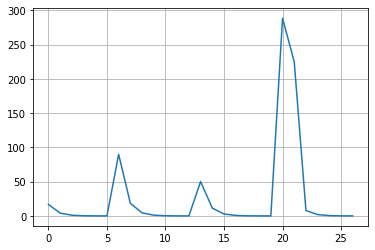

In [8]:
from matplotlib import pyplot as plt
plt.grid(True)
plt.plot(ev)

In [9]:
j_compute(phi[0],phi[1])

array([[[-2.36356074e-16]],

       [[-2.08264253e-31]],

       [[ 1.00000000e+00]]])

In [10]:
j_compute(phi[2],phi[3])

array([[[-0.07073356]],

       [[-0.99744365]],

       [[ 0.01014492]]])

In [11]:
print(f"check for singularities: {np.sin(phi[0])} and {np.sin(phi[2])}")

check for singularities: [-2.36356074e-16] and [-0.99994854]
